<a href="https://colab.research.google.com/github/abm4github/cardiovascular-risk-prediction_Supervised-Classification/blob/main/AlmaBetter_ML_Classification_CardioVascularRisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##HEART DISEASE RISK PREDICTION USING MACHINE LEARNING



##Dataset Attributes:

###Demographic:

sex: male or female(Nominal)

age: Age of the patient;(Continuous) - Although the recorded ages have been
     truncated to whole numbers, the concept of age is continuous)

education: no further information provided (ordinal)

##Behavioral:

is_smoking: whether or not the patient is a current smoker (Nominal)

cigsPerDay: the number of cigarettes that the person smoked on average in
one day.(can be considered continuous as one can have any number 
of cigarettes, even half a cigarette.)

##Information on medical history:

BPMeds: whether or not the patient was on blood pressure medication (Nominal prevalent Stroke: whether or not the patient had previously had a strok (Nominal)

prevalent Hyp: whether or not the patient was hypertensive (Nominal)

diabetes: whether or not the patient had diabetes (Nominal)

##Information on current medical condition:

totChol: total cholesterol level (Continuous)

sysBP: systolic blood pressure (Continuous)

diaBP: diastolic blood pressure (Continuous)

BMI: Body Mass Index (Continuous)

heartRate: heart rate (Continuous - In medical research, variables such as 
heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)

glucose: glucose level (Continuous)


##Target variable to predict:
TenYearCHD: 10 year risk of coronary heart disease (CHD) - (binary: “1”, means “Yes”, “0” means “No”)

In [ ]:
!pip install imbalanced-learn >> /dev/null
!pip install smote-variants >> /dev/null
!pip install CatBoost>> /dev/null
!pip install mglearn >>/dev/null
!pip install boruta>>/dev/nul

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics as s
from sklearn.impute import KNNImputer

from numpy import math


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,recall_score,precision_score
import smote_variants as sv
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import cohen_kappa_score
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
import mglearn

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report,roc_auc_score,recall_score,precision_score,classification_report,roc_auc_score, roc_curve,cohen_kappa_score,confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
##used to ignore warning messages
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading dataset
# data = pd.read_csv("/content/drive/MyDrive/Almabetter learning/Cardiovascular Risk Prediction/data_cardiovascular_risk.csv")
data = pd.read_csv("/content/drive/MyDrive/AlmaBetter ML Classification Deliverables/data_cardiovascular_risk.csv")
print("Dataset size")
print("Rows {} Columns {}".format(data.shape[0], data.shape[1]))

Dataset size
Rows 3390 Columns 17


##Data Analysis

In [ ]:
data.sample(5)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
750,750,46,2.0,M,YES,20.0,0.0,0,1,0,238.0,140.5,92.5,26.97,75.0,83.0,0
882,882,38,4.0,F,NO,0.0,0.0,0,0,0,227.0,99.0,62.0,27.16,75.0,90.0,0
1369,1369,39,2.0,M,NO,0.0,0.0,0,0,0,247.0,113.0,80.0,28.59,80.0,82.0,0
1915,1915,39,1.0,M,NO,0.0,0.0,0,0,0,224.0,108.0,66.0,28.57,90.0,97.0,0
2942,2942,42,3.0,F,NO,0.0,0.0,0,1,0,230.0,142.5,79.0,25.15,82.0,99.0,0


In [ ]:
# getting general stats on data
data.describe()

,id,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3390.000000,3303.000000,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
mean,1694.500000,49.542183,1.970936,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,978.753033,8.592878,1.019081,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,847.250000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,1694.500000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,2541.750000,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000
max,3389.000000,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


In [ ]:
# 'id' is dropped as it is not required
data.drop(columns=['id'],inplace=True)

In [ ]:
# Getting data features
data.columns

Index(['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

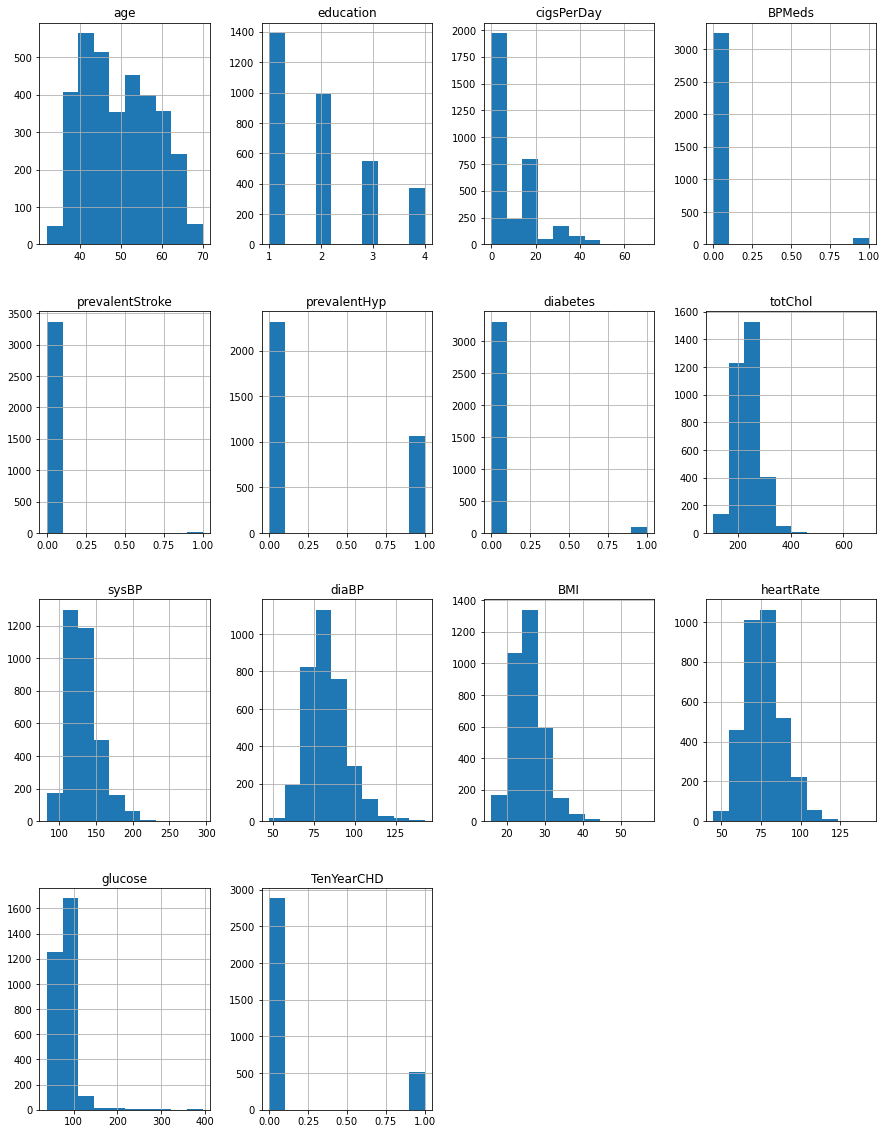

In [ ]:
# understanding distribution of data before imputation
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(ax = ax)
plt.show()

The data on the prevalent stroke, diabetes, and blood pressure meds are poorly balanced

Text(0.5, 1.0, 'Target Class Count')

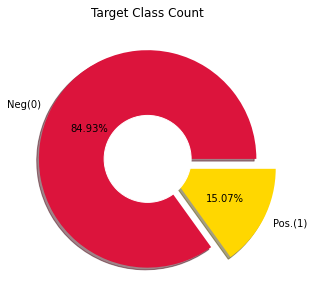

In [ ]:
#Target Class count, to check balance in data collection 

plt.figure(figsize=(5,5))
plt.pie(data['TenYearCHD'].value_counts(), labels=['Neg(0)','Pos.(1)'], autopct='%1.2f%%', explode=[0,0.2], shadow=True, colors=['crimson','gold'])
my_circle = plt.Circle( (0,0), 0.4, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Target Class Count')

Data is seen highly imbalanced, before fitting model to it, we need to balance it appropriately.

In [ ]:
# comparing categorical variables
def stacked_barchart(data, title = None, ylabel = None, xlabel = None):
    default_colors = ['#008080', '#5f3c41', '#219AD8']
    # From raw value to percentage
    totals = data.sum(axis=1)
    bars = ((data.T / totals) * 100).T
    r = list(range(data.index.size))

    # Plot
    barWidth = 0.5
    names = data.index.tolist()
    bottom = [0] * bars.shape[0]

    # Create bars
    color_index = 0
    plots = []
    for bar in bars.columns:
        plots.append(plt.bar(r,bars[bar],bottom=bottom, color=default_colors[color_index], edgecolor='white', width=barWidth))
        bottom = list(map(add, bottom, bars[bar]))
        color_index = 0 if color_index >= len(default_colors) else color_index + 1

    # Custom x axis
    plt.title(title)
    plt.xticks(r, names)
    plt.xlabel(data.index.name if xlabel is None else xlabel)
    plt.ylabel(data.columns.name if ylabel is None else ylabel)
    ax = plt.gca()
        
    y_labels = ax.get_yticks()
    ax.set_yticklabels([str(y) + '%' for y in y_labels])

    flat_list = [item for sublist in data.T.values for item in sublist]
    for i, d in zip(ax.patches, flat_list):
        data_label = str(d) + " (" + str(round(i.get_height(), 2)) + "%)"
        ax.text(i.get_x() + 0.45, i.get_y() + 5, data_label, horizontalalignment='right', verticalalignment='center', fontdict = dict(color = 'white', size = 10))

    for item in ([ax.title]):
        item.set_fontsize(13)
        
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(13)
    
    legend = ax.legend(plots, bars.columns.tolist(), fancybox=True )
    plt.setp(legend.get_texts(), fontsize='10')

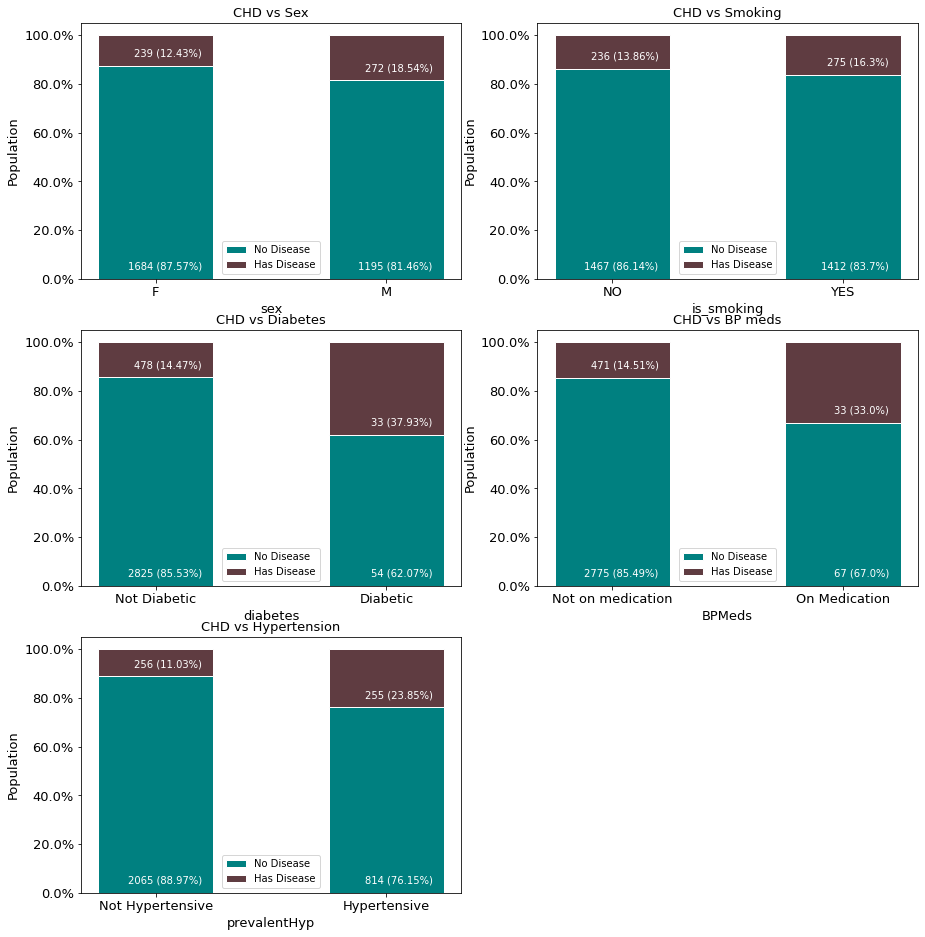

In [ ]:
from operator import add
fig = plt.gcf()
fig.set_size_inches(15, 16)
grid_rows = 3
grid_cols = 2

#draw sex vs disease outcome
plt.subplot(grid_rows, grid_cols, 1)
temp = data[['sex','TenYearCHD']].groupby(['sex','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Female', 1:'Male'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Sex', ylabel = 'Population')

#draw smoking satus vs disease outcome
plt.subplot(grid_rows, grid_cols, 2)
temp = data[['is_smoking','TenYearCHD']].groupby(['is_smoking','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not a Smoker', 1:'Smoker'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Smoking', ylabel = 'Population')

#draw diabetes vs disease outcome
plt.subplot(grid_rows, grid_cols, 3)
temp = data[['diabetes','TenYearCHD']].groupby(['diabetes','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not Diabetic', 1:'Diabetic'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Diabetes', ylabel = 'Population')

#draw BP meds vs disease outcome
plt.subplot(grid_rows, grid_cols, 4)
temp = data[['BPMeds','TenYearCHD']].groupby(['BPMeds','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not on medication', 1:'On Medication'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs BP meds', ylabel = 'Population')

#draw Hypertension vs disease outcome
plt.subplot(grid_rows, grid_cols, 5)
temp = data[['prevalentHyp','TenYearCHD']].groupby(['prevalentHyp','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not Hypertensive', 1:'Hypertensive'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Hypertension', ylabel = 'Population')


Due to the imbalanced nature of the dataset it is difficult to make conclusions but based on what is observed but these are the conclusions that can be drawn:

* Slightly more males are suffering from CHD than females
* The percentage of people who have CHD is almost equal between smokers and non smokers
* The percentage of people who have CHD is higher among the diabetic, and those with prevalent hypertesion as compared to those who dont have similar morbidities
* A larger percentage of the people who have CHD are on blood pressure medication

In [ ]:
# Checking missing values if any
data.isna().sum()

age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

In [ ]:
#total percentage of missing data
missing_data = data.isnull().sum()
total_percentage = (missing_data.sum()/data.shape[0]) * 100
print(f'The total percentage of missing data is {round(total_percentage,2)}%')

The total percentage of missing data is 15.04%


Missing data is in considerable percentage, therefore, it needs to be treated with appropriate imputation rather than deleting them

In [ ]:
# percentage of missing data as per category
total = data.isnull().sum().sort_values(ascending=False)
percent_total = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100
missing = pd.concat([total, percent_total], axis=1, keys=["Total", "Percentage"])
missing_data = missing[missing['Total']>0]
missing_data

,Total,Percentage
glucose,304,8.967552
education,87,2.566372
BPMeds,44,1.297935
totChol,38,1.120944
cigsPerDay,22,0.648968
BMI,14,0.412979
heartRate,1,0.029499


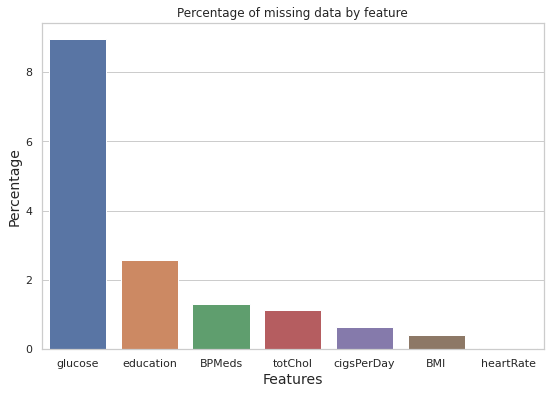

In [ ]:
# visualizing percentage of missing data by feature
plt.figure(figsize=(9,6))
sns.set(style="whitegrid")
sns.barplot(x=missing_data.index, y=missing_data['Percentage'], data = missing_data)
plt.title('Percentage of missing data by feature')
plt.xlabel('Features', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.show()

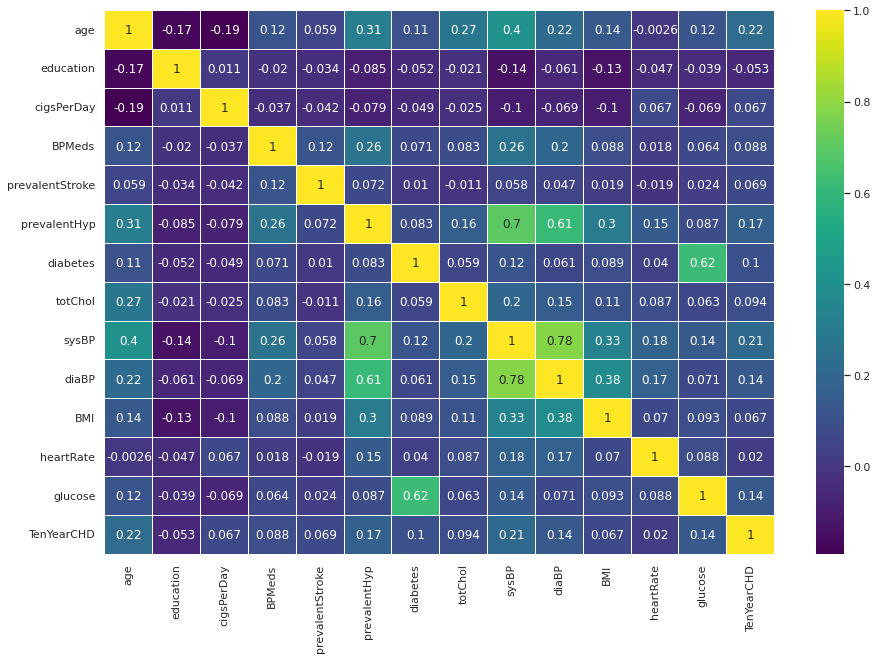

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(),annot=True,cmap='viridis', linewidths=.1)
plt.show()

There are no features with more than 0.5 correlation with the Ten year risk of developing CHD and this shows that the features a poor predictors. 
However the features with the highest correlations are 
* age
* prevalent hypertension
* systolic blood pressure

Also there are a couple of features that are highly correlated with one another and it makes no sense to use both of them in building a machine learning model. These include: 
* systolic and diastolic blood pressures
* cigarette smoking and the number of cigarretes smoked per day

## Data Cleaning for modeling

From above analysis, we can conclude that the data needs following treatment before modeling

* Encoding categorical data
* Handling missing data
* Removal of Highly correlated data
* Balancing dataset based on target variable.

## Encoding categorical data

In [ ]:
# Encoding the categorical columns
data['is_smoking']=data['is_smoking'].apply(lambda x:1 if x=='YES' else 0)
data['sex']=data['sex'].apply(lambda x:1 if x=='M' else 0)

## Handling missing data

In [ ]:
#Check values of diabetes where glucose is null
data[data['glucose'].isna()]['diabetes'].value_counts()

0    301
1      3
Name: diabetes, dtype: int64

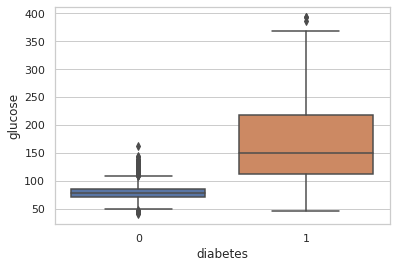

In [ ]:
#Variation of glucose levels in diabetic and non-diabetic person
sns.boxplot(data=data,x='diabetes',y='glucose');

In [ ]:
## Null handling for column glucose
data.loc[(data['glucose'].isna()) & (data['diabetes']==0) ,['glucose'] ]=data[data['diabetes']==0]['glucose'].median()
data.loc[(data['glucose'].isna()) & (data['diabetes']==1) ,['glucose'] ]=data[data['diabetes']==1]['glucose'].median()

In [ ]:
# Imputed null values with mode
data['BPMeds']=data['BPMeds'].fillna(s.mode(data['BPMeds']))

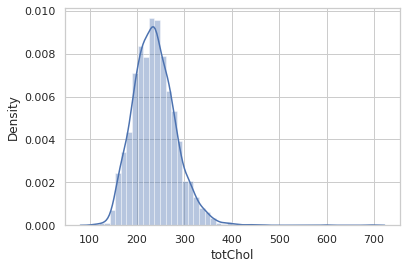

In [ ]:
sns.distplot(data['totChol']);

In [ ]:
# Impute with median
data['totChol']=data['totChol'].fillna(data['totChol'].median())

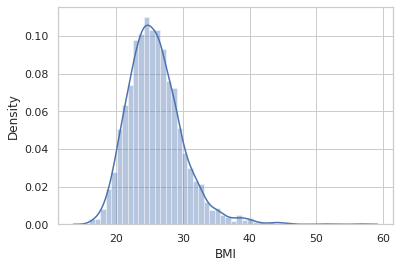

In [ ]:
sns.distplot(data['BMI']);

In [ ]:
# Impute with median
data['BMI']=data['BMI'].fillna(data['BMI'].median())

In [ ]:
## CigsPerDay 22 nulls needs imputation as is_smoking is yes all 22 records
data[(data.cigsPerDay.isna()) & (data.is_smoking!='YES')]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
422,55,1.0,0,1,NaN,0.0,0,1,0,213.0,163.0,91.0,28.66,69.0,66.0,0
466,45,3.0,1,1,NaN,0.0,0,1,0,170.0,145.5,99.0,26.74,83.0,85.0,0
469,42,1.0,1,1,NaN,0.0,0,0,0,196.0,123.0,73.0,22.06,66.0,78.0,0
491,61,1.0,0,1,NaN,0.0,0,1,0,356.0,168.0,98.0,27.30,103.0,106.0,0
538,41,1.0,0,1,NaN,0.0,0,0,0,171.0,135.0,82.5,24.35,79.0,82.0,0
767,54,1.0,1,1,NaN,0.0,0,0,0,219.0,110.0,72.0,26.05,95.0,86.0,0
1461,47,2.0,0,1,NaN,0.0,0,0,0,365.0,127.0,76.0,24.44,72.0,80.0,0
1467,49,1.0,0,1,NaN,0.0,0,0,0,252.0,123.0,69.0,21.45,72.0,89.0,0
1597,57,NaN,0,1,NaN,0.0,0,0,0,229.0,115.0,69.0,24.43,80.0,93.0,0
1986,49,2.0,0,1,NaN,0.0,0,1,0,233.0,158.0,102.0,25.31,90.0,72.0,0


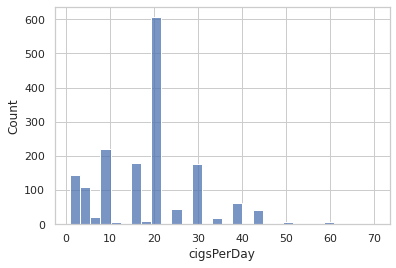

In [ ]:
# Barplot of Cigs per day
sns.histplot(data[data['cigsPerDay']!=0]['cigsPerDay'],bins=30);
## Bar plot gives an idea about what count of cigsperday is observed in more numbers

In [ ]:
# Impute with random number between 5 and 30
data['cigsPerDay']=data['cigsPerDay'].fillna(np.random.randint(5,30))

In [ ]:
# Impute with mean, only one null value
data['heartRate']=data['heartRate'].fillna(np.mean(data['heartRate']))

In [ ]:
data.isna().sum()

age                 0
education          87
sex                 0
is_smoking          0
cigsPerDay          0
BPMeds              0
prevalentStroke     0
prevalentHyp        0
diabetes            0
totChol             0
sysBP               0
diaBP               0
BMI                 0
heartRate           0
glucose             0
TenYearCHD          0
dtype: int64

In [ ]:
#data[data['glucose'].isna()]
# define imputer
imputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')

In [ ]:
# fit on the dataset
imputer.fit(data)

KNNImputer(n_neighbors=10)

In [ ]:
# transform the dataset
data_trans = pd.DataFrame(imputer.transform(data),columns=data.columns)

In [ ]:
data_trans.isna().sum().sum()

0

In [ ]:
data=data_trans.copy()

## Removal of highly correlated data

In [ ]:
data.columns

Index(['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [ ]:
#storing the difference between sysBP and diaBP in a new variable 'pulse'  
data['pulse']=data['sysBP']-data['diaBP']


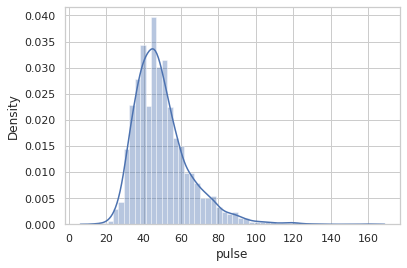

In [ ]:
# Distribution of pulse
sns.distplot(data['pulse'])

In [ ]:
# deleting highly correlated features
data=data.drop(['is_smoking','sysBP','diaBP'],axis=1)

In [ ]:
data.columns

Index(['age', 'education', 'sex', 'cigsPerDay', 'BPMeds', 'prevalentStroke',
       'prevalentHyp', 'diabetes', 'totChol', 'BMI', 'heartRate', 'glucose',
       'TenYearCHD', 'pulse'],
      dtype='object')

## Balancing dataset on basis of target variable count

In [ ]:
# Split traget and independent features
X=data.drop(['TenYearCHD'],axis=1).values
y=data['TenYearCHD'].values

In [ ]:
data.isnull().sum()

age                0
education          0
sex                0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
pulse              0
dtype: int64

In [ ]:
# handling data imbalance data
oversampler= sv.distance_SMOTE()
X_msmote, y_msmote= oversampler.sample(X, y)

2022-01-03 10:22:12,511:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


In [ ]:
#Create new Dataframe with balanced data
data_new=pd.DataFrame(X_msmote,columns=data.columns[:-1])
data_new['TenYearCHD']=pd.DataFrame(y_msmote)
data_new['TenYearCHD'].value_counts()

0.0    2879
1.0    2879
Name: TenYearCHD, dtype: int64

##Feature Selection

In [ ]:
from boruta import BorutaPy

In [ ]:
X = data_new.iloc[:,:-1].values
y = data_new.iloc[:,-1].values

In [ ]:
y

array([1., 0., 0., ..., 1., 1., 1.])

In [ ]:
X.shape

(5758, 12)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced')

In [ ]:
# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2)

In [ ]:
# find all relevant features
feat_selector.fit(X, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	2


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	2


BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          n_estimators=48, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F7D12A1A050),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F7D12A1A050, verbose=2)

In [ ]:
# show the most important features
most_important = data_new.columns[:-1][feat_selector.support_].tolist()
most_important

['age',
 'education',
 'sex',
 'cigsPerDay',
 'BPMeds',
 'prevalentHyp',
 'totChol',
 'BMI',
 'heartRate',
 'glucose']

We see that age and systolic blood pressures are selected as the most important features for predicting the Ten year risk of developing CHD.

However we will use the six most important features to build our models

In [ ]:
# select the top 6 features
top_features = data_new.columns[:-1][feat_selector.ranking_ <=6].tolist()
print(f'top features are: {top_features}')

top features are: ['age', 'education', 'sex', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'BMI', 'heartRate', 'glucose']


## Data preparation

In [ ]:
# Split traget and independent features
X=data_new[top_features]
y=data_new['TenYearCHD']

In [ ]:
X.head()

,age,education,sex,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,BMI,heartRate,glucose
0,64.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,221.0,25.38,90.0,80.0
1,36.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,212.0,29.77,72.0,75.0
2,46.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,250.0,20.35,88.0,94.0
3,50.0,1.0,1.0,20.0,0.0,0.0,1.0,0.0,233.0,28.26,68.0,94.0
4,64.0,1.0,0.0,30.0,0.0,0.0,0.0,0.0,241.0,26.42,70.0,77.0


In [ ]:
# Split data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=10)

In [ ]:
# Scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Now, the scaled data is ready to fit machine learning models on it

In [ ]:
# Metrics
metrics_df=pd. DataFrame(index=['ROC-AUC','Precision','Recall','F1-Score','Accuracy','Cohens Kappa Score'])

We create an empty DataFrame to store the results of diffrent scores like ROC-AUC,Precision,Recall,F1-Score,Accuracy,Cohens Kappa Score. As we test our models we will fill this dataframe with the values obtained in each step.

After having our data ready we proceed to implement Machine learning models.

# Support Vector Classifier

In [ ]:
# Define model
svc = SVC(kernel='rbf', C=1E6,random_state=1,probability=True)
#Fit the train data
svc.fit(X_train, y_train)
# Predict the test data
y_pred_svc=svc.predict(X_test)

We fit a Support vector classifier over here by choosing kernel as radial basis function. This model is used to fit the test data.

In [ ]:
# Print confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)
print(cm)

[[589 148]
 [ 93 610]]


In [ ]:
## Calculate the diff Metrics
roc_auc = roc_auc_score(y_test, y_pred_svc)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
f1=2*precision*recall/(recall+precision)
print ("F1-Score {:.3f}".format(f1))
accuracy =accuracy_score(y_test, y_pred_svc)
print("Accuracy {:.3f}".format(accuracy))
kappa=cohen_kappa_score(y_test, y_pred_svc)
print("Cohen's Kappa Score {:.3f}".format(kappa))


ROC-AUC: 0.833
Precision: 0.805
Recall: 0.868
F1-Score 0.835
Accuracy 0.833
Cohen's Kappa Score 0.666


We compare the different scores obtained here. We can observe the scores to be good. With further tuning we would check if it can be improved.

In [ ]:
# Calculate train and test class probabilities
train_preds=svc.predict_proba(X_train)
test_preds=svc.predict_proba(X_test)

## Transform the predicted array to Dataframe
train_preds_df=pd.DataFrame(train_preds,columns=['No','Yes'])
train_preds=np.array(train_preds_df['Yes'])

## For test data
test_preds_df=pd.DataFrame(test_preds,columns=['No','Yes'])
test_preds=np.array(test_preds_df['Yes'])

Here we calculate the probabilities to plot the ROC curve and check if we get better results by moving the threshold for calculating the classes.

Best Threshold=0.432329, G-Mean=1.000


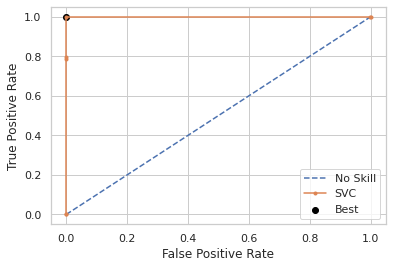

In [ ]:
## Calculate optimal threshold using roc_curve method
fpr, tpr, thresholds = roc_curve(y_train, train_preds)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# Locate the index of the largest geometric mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))


# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='SVC' , marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
# Calculate class of test data
test_preds_class=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>thresholds[ix] else 0))

Based on the above ROC curve, we try to find the optimal threshold for which we get a balance of the true and false positive rates. We calculate the maximum value of geometric means and use this point as a threshold to calculate the prediction class.

In [ ]:
## Calculate the diff Metrics
roc_auc = roc_auc_score(y_test, test_preds_class)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, test_preds_class)
recall = recall_score(y_test, test_preds_class)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, test_preds_class)
print("Accuracy {:.3f}".format(accuracy))
print("Cohen's Kappa Score {:.3f}".format(cohen_kappa_score(y_test, test_preds_class)))


ROC-AUC: 0.853
Precision: 0.854
Recall: 0.842
F1-Score 0.848
Accuracy 0.853
Cohen's Kappa Score 0.705


The different scores are calculated based on the new predictions. We do not observe any improvements in different scores based on this approach.

We would check if we can improve the performance by tuning the hyper parameters.

In [ ]:
#Define hyper parameters to tune

param_grid = {'C': [0.1, 1, 10, 100, 1000,100000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)
 
# fitting the model for grid search
grid.fit(X_train, y_train )

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 100000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=1)

A Grid search is done for parameters C and gamma. The kernel chosen is Radial Basis function. C controls the error in the model and gammma defines the curvature in the decision boundary

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1, gamma=1)


So after obtaining the optimal parameters for C and gamma as seen above, we can use this for predicting our test dataset.

In [ ]:
# Predict the test data set class
y_grid_predictions = grid.predict(X_test)

We predict the test data set using the parameters obtained.

In [ ]:
## Calculate the diff Metrics
roc_auc = roc_auc_score(y_test, y_grid_predictions)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, y_grid_predictions)
recall = recall_score(y_test, y_grid_predictions)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
f1=2*precision*recall/(recall+precision)
print ("F1-Score {:.3f}".format(f1))
accuracy =accuracy_score(y_test, y_grid_predictions)
print("Accuracy {:.3f}".format(accuracy))
kappa=cohen_kappa_score(y_test, y_grid_predictions)
print("Cohen's Kappa Score {:.3f}".format(kappa))


ROC-AUC: 0.904
Precision: 0.931
Recall: 0.869
F1-Score 0.899
Accuracy 0.905
Cohen's Kappa Score 0.809


It can be observed that after hyper parameter tuning, there is significant improvements in the scores. We get an excellent Cohen's Kappa score and a good Recall value as well.

In [ ]:
# Store the metrics in a dataframe
metrics_df['SVC']=[roc_auc,precision,recall,f1,accuracy,kappa]

Storing the scores in a DataFrame for comparing the performace with respect to other models.

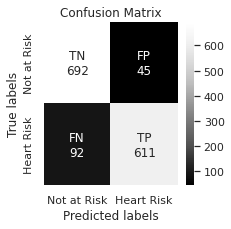

In [ ]:
# Get the confusion matrix for test
plt.figure(figsize=(3,3))
labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, y_grid_predictions)

cat = ['TN','FP','FN','TP']
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=labelsIn,cmap='Greys_r', fmt='')

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

The confusion matrix displays the True positives (TP), False Negatives (FN), False positives (FP) and True Negatives (TN).

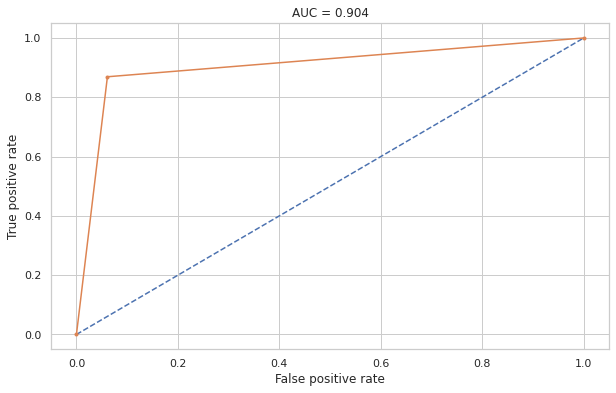

In [ ]:
# ROC curve and AUC 

# calculate AUC
log_auc = roc_auc_score(y_test, y_grid_predictions)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_grid_predictions)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

We plot the ROC curve for the data here. It can be observed we are getting a good area under curve value.

##K-Nearest Neighbors (K-NN)

Now we proceed to train our data with K-Nearest neighbors model.

In [ ]:
## Define the KNN model
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

Training the K-NN model on the Training set

In [ ]:
# Predict the test data
y_pred = classifier.predict(X_test)

Here we predict the test data.

In [ ]:
## Calculate the diff Metrics
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred)
print("Accuracy {:.3f}".format(accuracy))
kappa=cohen_kappa_score(y_test, y_pred)
print("Cohen's Kappa Score {:.3f}".format(kappa))

# Get the confusion matrix for test

cm = confusion_matrix(y_test, y_pred)
print(cm)


ROC-AUC: 0.844
Precision: 0.799
Recall: 0.905
F1-Score 0.849
Accuracy 0.842
Cohen's Kappa Score 0.686
[[577 160]
 [ 67 636]]


It can be observed that the Cohen's kappa score is not high. Rest of the scores obtained using KNN seems good but we would go for hyper parameter tuning to find whether we get better scores.

*Hyperparameter optimization*



In [ ]:
#Define hyper parameters to tune
grid_params = { 'n_neighbors' : [5,7,9,11,13],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
knn = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=5, n_jobs = -1)

We define the grid search parameters through which our model will iterate. n_neighbors is for the number of nearest neighbors the data points is going to look for, weights is for the weights assigned to the data points in a neighborhood and metric is the distance metric to be used.

In [ ]:
# fit the model on our train set
g_res = knn.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


The model is fitted on training data with the grid search parameters.

In [ ]:
#best parameters
print(g_res.best_params_)

# find the best score
print(g_res.best_score_)


{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
0.8925386785974851


Calling the best_params_ we get the dictionary showing the optimal parameters and we call the best_score_ to get the score corresponding to these optimal parameters.

In [ ]:
# get a prediction
y_hat = knn.predict(X_train)
y_knn = knn.predict(X_test)

After obtaining the parameters we predict the class for our train and test dataset.

In [ ]:
## Calculate the diff Metrics
roc_auc = roc_auc_score(y_test, y_knn)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, y_knn)
recall = recall_score(y_test, y_knn)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
f1=2*precision*recall/(recall+precision)
print ("F1-Score {:.3f}".format(f1))
accuracy =accuracy_score(y_test, y_knn)
print("Accuracy {:.3f}".format(accuracy))
kappa=cohen_kappa_score(y_test, y_knn)
print("Cohen's Kappa Score {:.3f}".format(kappa))


ROC-AUC: 0.913
Precision: 0.890
Recall: 0.936
F1-Score 0.913
Accuracy 0.912
Cohen's Kappa Score 0.825


It can be observed that the Cohen's kappa score improved significantly after hyper parameter tuning. We can also observe improvements in Recall, Precision and F1-score.

In [ ]:
# Store the different metrics in dataframe
metrics_df['KNN']=[roc_auc,precision,recall,f1,accuracy,kappa]

Here we store the different metrics in a dataframe that can be used for comparison.

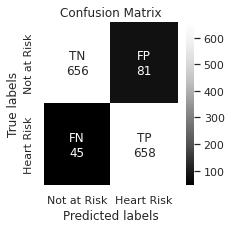

In [ ]:
# Get the confusion matrix for test
plt.figure(figsize=(3,3))
labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, y_knn)

cat = ['TN','FP','FN','TP']
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
#sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

sns.heatmap(cm, annot=labelsIn, cmap='Greys_r', fmt='')

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

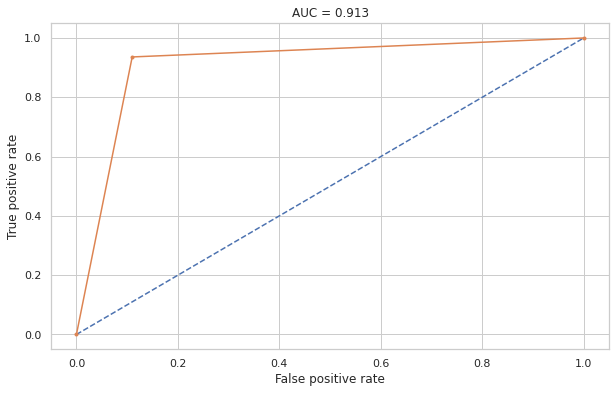

In [ ]:
# ROC curve and AUC 

# calculate AUC
log_auc = roc_auc_score(y_test, y_knn)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_knn)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--',label='No Skill')
plt.plot(fpr, tpr, marker='.',label='KNN')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

This shows the ROC curve where the area under curve is 0.901

## Decision Tree Classification

In [ ]:
# Define and fit the model
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

Training the Decision Tree classification model on the training data set.

Making the Confusion matrix

In [ ]:
# Predict test data
y_pred = classifier.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(597, 652, 85, 106)

Using the above model we predict the test data.

In [ ]:
## Calculate the diff Metrics
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
f1=2*precision*recall/(recall+precision)
print ("F1-Score {:.3f}".format(f1))
accuracy =accuracy_score(y_test, y_pred)
print("Accuracy {:.3f}".format(accuracy))
kappa=cohen_kappa_score(y_test, y_pred)
print("Cohen's Kappa Score {:.3f}".format(kappa))


ROC-AUC: 0.867
Precision: 0.875
Recall: 0.849
F1-Score 0.862
Accuracy 0.867
Cohen's Kappa Score 0.734


After predicting the test data using Decision Tree classifier, We compute the diffrent scores on the test data.

In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print("")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.55034722 0.63541667 0.92881944 0.91319444 0.91319444 0.91666667
 0.89236111 0.91319444 0.92521739 0.8973913 ]

The Cross Validation accuracy is: 84.86%


*Classification report*

In [ ]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87       737
         1.0       0.88      0.85      0.86       703

    accuracy                           0.87      1440
   macro avg       0.87      0.87      0.87      1440
weighted avg       0.87      0.87      0.87      1440



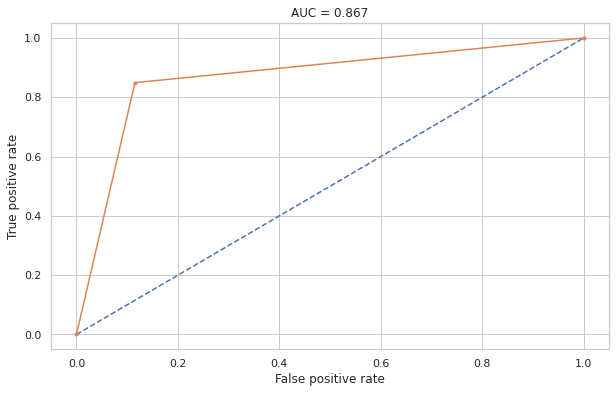

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--',label='No Skill')
plt.plot(fpr, tpr, marker='.',label='Decision Tree')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

*Hyper parameter tuning*

In [ ]:
# Define parameters for tuning
dt = DecisionTreeClassifier(random_state=42)
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

The diffrent parameters for which we would be iterating using Grid search are defined. The max_depth defines the depth of tree, min_samples_leaf says is the minimum number of samples that must be present in a leaf for further split and criterion measures the quality of split.

In [ ]:
# Define Grid Search
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

# Fit grid search on train data
%time
grid_search.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

The training data is fitted with four fold cross validation and accuracy as the scoring method.

In [ ]:
# Display the grid search results
score_df = pd.DataFrame(grid_search.cv_results_)
#score_df.head()
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
35,0.021029,0.003212,0.001252,0.000169,entropy,5,5,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.895370,0.892593,0.910102,0.890639,0.897176,0.007650,1
36,0.018544,0.000024,0.001169,0.000033,entropy,5,10,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.895370,0.892593,0.910102,0.889713,0.896944,0.007855,2
10,0.013506,0.001511,0.001234,0.000063,gini,5,5,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.892593,0.890741,0.910102,0.890639,0.896019,0.008168,3
11,0.012463,0.000331,0.001078,0.000029,gini,5,10,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.891667,0.888889,0.910102,0.889713,0.895093,0.008724,4
37,0.018482,0.000049,0.001180,0.000028,entropy,5,20,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.895370,0.892593,0.906395,0.876738,0.892774,0.010600,5


This dataframe shows the fit results for five largest mean test scores.

In [ ]:
# Get the best estimator
grid_search.best_estimator_
dt_best = grid_search.best_estimator_

# Storing the best parameters
max_depth = grid_search.best_params_['max_depth']
min_samples_leaf =  grid_search.best_params_['min_samples_leaf']
criterion = grid_search.best_params_['criterion']


In [ ]:
# Fit using the optimal parameters
classifier_tuning = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       random_state=42)
classifier_tuning.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5,
                       random_state=42)

After obtaining the optimal parameters we use them in our deicsion tree classification model to fit the training data again.

In [ ]:
# Predict the test data
y_pred = classifier_tuning.predict(X_test)

Predict the test data using the tuned model

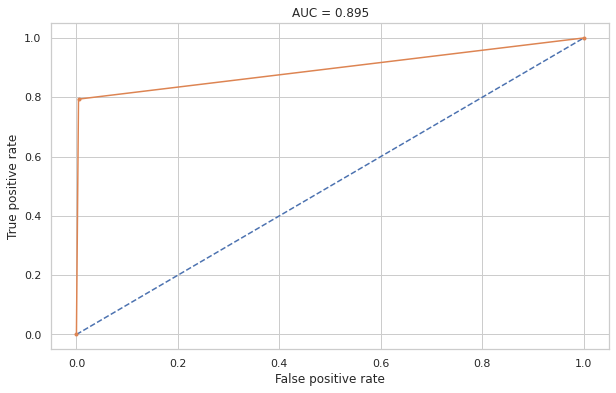

In [ ]:
# ROC curve and AUC 
probs = classifier_tuning.predict(X_test)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--',label='No Skill')
plt.plot(fpr, tpr, marker='.',label='Decision Tree')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

A ROC curve is plotted with the test data set predictions to observe the area under curve. We can see a good AUC value.

In [ ]:
## Calculate the diff Metrics
roc_auc = roc_auc_score(y_test, probs)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, probs)
recall = recall_score(y_test, probs)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
f1=2*precision*recall/(recall+precision)
print ("F1-Score {:.3f}".format(f1))
accuracy =accuracy_score(y_test, probs)
print("Accuracy {:.3f}".format(accuracy))
kappa=cohen_kappa_score(y_test, probs)
print("Cohen's Kappa Score {:.3f}".format(kappa))


ROC-AUC: 0.895
Precision: 0.995
Recall: 0.794
F1-Score 0.883
Accuracy 0.897
Cohen's Kappa Score 0.793


We display all the scores together for the tuned decision tree model. The Cohen's Kappa score has improved a bit. Even though we see a comparitively better F1 score the Recall has decreased. The F1-score seems to be inflated due to high precision.

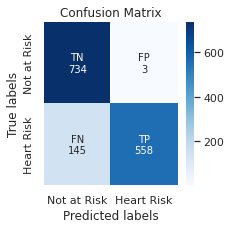

In [ ]:
# Get the confusion matrix
plt.figure(figsize=(3,3))
labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, y_pred)

cat = ['TN','FP','FN','TP']
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

The model is used to predict the test data and the confusion matrix displays the True positives (TP), False Negatives (FN), False positives (FP) and True Negatives (TN).

In [ ]:
# Store the different metrics in dataframe
metrics_df['DecTree']=[roc_auc,precision,recall,f1,accuracy,kappa]

The scores are stored in a dataframe which would be used for overall comparison of models.

# Random Forest Classifier

In [ ]:
## Define Random Forest model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

Now we fit a Random forest classifier that use ensembles of decision trees.

---



In [ ]:
# Predict the test data
y_pred_rfc=rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rfc)
print(cm)

[[729   8]
 [121 582]]


The Random forest classifier model is used to predict the test dataset.

In [ ]:
## Calculate the diff Metrics
roc_auc = roc_auc_score(y_test, y_pred_rfc)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, y_pred_rfc)
recall = recall_score(y_test, y_pred_rfc)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
f1=2*precision*recall/(recall+precision)
print ("F1-Score {:.3f}".format(f1))
accuracy =accuracy_score(y_test, y_pred_rfc)
print("Accuracy {:.3f}".format(accuracy))
kappa=cohen_kappa_score(y_test, y_pred_rfc)
print("Cohen's Kappa Score {:.3f}".format(kappa))


ROC-AUC: 0.909
Precision: 0.986
Recall: 0.828
F1-Score 0.900
Accuracy 0.910
Cohen's Kappa Score 0.820


With a simple model we calculate the different scores. 

In [ ]:
#Cross Validation
cv_results = cross_val_score(rfc, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.50694444 0.61805556 0.99479167 0.984375   0.99305556 0.98958333
 0.98611111 0.98611111 0.99304348 0.98956522]
The Cross Validation accuracy is: 90.42%


*Hyper parameter tuning*

In [ ]:
# Hypertuning using grid search cv
grid_params = { 'n_estimators': [100, 300],
              'max_depth': [8, 15, 25, 30],
              'min_samples_split': [2, 15, 100],
              'min_samples_leaf': [2, 10], 
              'criterion':['gini', 'entropy']}
clf = GridSearchCV(RandomForestClassifier(), grid_params, cv= 5)
# fit the model on our train set
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [8, 15, 25, 30],
                         'min_samples_leaf': [2, 10],
                         'min_samples_split': [2, 15, 100],
                         'n_estimators': [100, 300]})

We are using Grid search for finding optimal parameters. Here we have chosen to iterate through parameters like n_estimators which is for the number of trees in our random forest model, max_depth is for the maximum depth of trees, min_samples_split is for the minimum number of data points required for a further split and criterion is the measure for quality of split.

In [ ]:
# Storing the best parameters
n_estimators = clf.best_params_['n_estimators']
max_depth = clf.best_params_['max_depth']
min_samples_split = clf.best_params_['min_samples_split']
min_samples_leaf =  clf.best_params_['min_samples_leaf']
criterion = clf.best_params_['criterion']
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 300}

The optimal parameters are printed here.

In [ ]:
## Define Random Forest model with best parameters

clf_tuned = RandomForestClassifier(n_estimators = n_estimators,
                                    max_depth = max_depth, 
                                    min_samples_split = min_samples_split, 
                                    min_samples_leaf =  min_samples_leaf,
                                    criterion = criterion)
clf_tuned.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2,
                       min_samples_split=15, n_estimators=300)

Now the test data is fitted with the help of tuned Random forest classifier.

In [ ]:
# Calculate train and test class probabilities
train_preds=clf_tuned.predict_proba(X_train)
test_preds=clf_tuned.predict_proba(X_test)

## Transform the predicted array to Dataframe
train_preds_df=pd.DataFrame(train_preds,columns=['No','Yes'])
train_preds=np.array(train_preds_df['Yes'])

## For test data
test_preds_df=pd.DataFrame(test_preds,columns=['No','Yes'])
test_preds=np.array(test_preds_df['Yes'])

The probabilities are calculated and the values are stored in a Dataframe. Yes represents the probability for predicting the label as having risk of Heart disease and vice-versa.

Best Threshold=0.351297, G-Mean=0.966


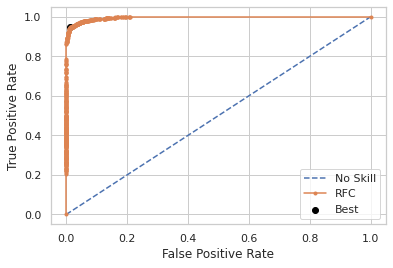

In [ ]:
## Calculate optimal threshold using roc_curve method
fpr, tpr, thresholds = roc_curve(y_train, train_preds)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# Locate the index of the largest geometric mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))


# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='RFC' , marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

# Calculate class of test data
test_preds_class=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>thresholds[ix] else 0))

The optimal threshold for diffrentiating the class is identified with the help of the roc_courve and after predicting the probabilities for our test dataset, we use this threshold to differentiate the class labels.

In [ ]:
## Calculate the diff Metrics
roc_auc = roc_auc_score(y_test, test_preds_class)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, test_preds_class)
recall = recall_score(y_test, test_preds_class)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, test_preds_class)
print("Accuracy {:.3f}".format(accuracy))
print("Cohen's Kappa Score {:.3f}".format(cohen_kappa_score(y_test, test_preds_class)))


ROC-AUC: 0.898
Precision: 0.928
Recall: 0.859
F1-Score 0.892
Accuracy 0.899
Cohen's Kappa Score 0.797


With the help of newly predicted data we calculate the diffrent scores and compare with our prior Random Forest model which was not tuned.

In [ ]:
#Cross Validation
cv_results = cross_val_score(clf_tuned, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.5        0.61458333 0.99826389 0.98784722 1.         0.99305556
 0.98784722 0.99131944 0.99826087 0.99478261]
The Cross Validation accuracy is: 90.66%


Metrics show that Random Forest Classifier's performance is better with its default parameters, and the cross validation scores are not showing any significant improvement after tuning, therefore we consider our model with default parameters.

In [ ]:
# Store the scores in a Dataframe
metrics_df['RF']=[roc_auc,precision,recall,f1,accuracy,kappa]

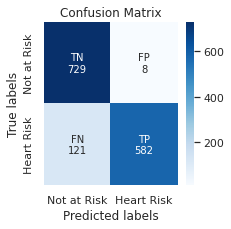

In [ ]:
# Get the confusion matrix for test dataset
plt.figure(figsize=(3,3))
labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, y_pred_rfc)

cat = ['TN','FP','FN','TP']
#cat = np.asarray(labels2).reshape(2,2)
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot();
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

The confusion matrix displays the True positives (TP), False Negatives (FN), False positives (FP) and True Negatives (TN).

# Bagging Classifier

In [ ]:
# Define models and parameters
model = BaggingClassifier()

# define grid search
grid = {'n_estimators':[50, 100,500, 1000]}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.941030 using {'n_estimators': 500}
0.940342 (0.006011) with: {'n_estimators': 50}
0.939922 (0.005984) with: {'n_estimators': 100}
0.941030 (0.006178) with: {'n_estimators': 500}
0.940898 (0.005968) with: {'n_estimators': 1000}


After Random Forest we use another ensemble method i.e Bagging Classifier. We have used the default base classifier of Decision tree and then do a Grid search using Repeated stratified five fold cross validation and scoring criterion as roc_auc to find the optimal number of estimators. The area under curve value obtained are almost same and close to 0.94.

In [ ]:
# Model the classifier with best params and fit
clf_bag=BaggingClassifier(n_estimators=grid_result.best_params_['n_estimators'],random_state=10).fit(X_train,y_train)

# Predict test data
y_pred_bag=clf_bag.predict(X_test)

The best number of estimator obtained from Grid serach is used to fit the data and then predict the test daatset.

In [ ]:
## Calculate the diff Metrics
roc_auc = roc_auc_score(y_test, y_pred_bag)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, y_pred_bag)
recall = recall_score(y_test, y_pred_bag)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
f1=2*precision*recall/(recall+precision)
print ("F1-Score {:.3f}".format(f1))
accuracy =accuracy_score(y_test, y_pred_bag)
print("Accuracy {:.3f}".format(accuracy))
kappa=cohen_kappa_score(y_test, y_pred_bag)
print("Cohen's Kappa Score {:.3f}".format(kappa))


ROC-AUC: 0.896
Precision: 0.953
Recall: 0.832
F1-Score 0.888
Accuracy 0.898
Cohen's Kappa Score 0.795


Here we have the diffrent scores for Bagging classifier, a very good Cohen's kappa score of around 0.8 and almost perfect Precision.

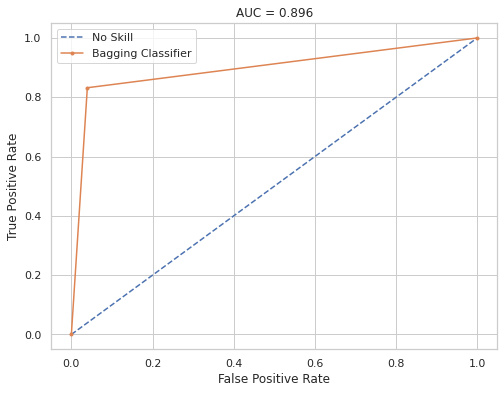

In [ ]:
## Display ROC curve
plt.figure(figsize=(8,6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_bag)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='Bagging Classifier' , marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f"AUC = {round(roc_auc,3)}")
# show the plot
plt.show()


From above we can see the ROC curve for Bagging classifier.

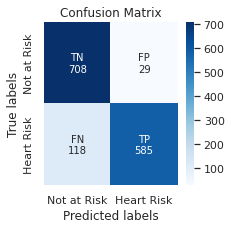

In [ ]:
# Get the confusion matrix for test
plt.figure(figsize=(3,3));
labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, y_pred_bag)

cat = ['TN','FP','FN','TP']
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot();
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

The confusion matrix displays the True positives (TP), False Negatives (FN), False positives (FP) and True Negatives (TN).

In [ ]:
# Store the scores in a Dataframe
metrics_df['Bagging']=[roc_auc,precision,recall,f1,accuracy,kappa]

The scores are stored in a Dataframe for different model comparisons afterwards.

# AdaBoost

In [ ]:
# Tune number of estimators
model = AdaBoostClassifier(random_state=1)
# Values for number of estimators
n_estimators = [10,50, 100,200,500, 800,1000]

# define grid search
grid = {'n_estimators':[10,50, 100,200,500, 800,1000]}
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.896804 using {'n_estimators': 50}
0.876884 (0.013509) with: {'n_estimators': 10}
0.896804 (0.011539) with: {'n_estimators': 50}
0.896098 (0.009056) with: {'n_estimators': 100}
0.893939 (0.011029) with: {'n_estimators': 200}
0.895338 (0.010474) with: {'n_estimators': 500}
0.893538 (0.009093) with: {'n_estimators': 800}
0.891456 (0.008201) with: {'n_estimators': 1000}


After Bagging we use another Adaptive Boosting. Initially we find the optimal number of estimators using Grid search and five fold croos validation with scoring criterion as F1(Harmonic mean of precision and recall).

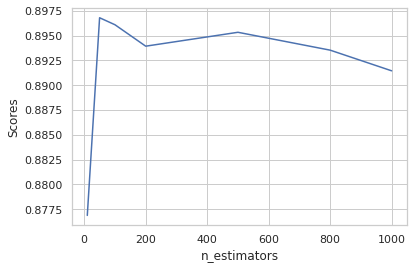

In [ ]:
# Create dataframe for Scores corresponding to no of estimators
params = grid_result.cv_results_['param_n_estimators']
df_scores=pd.DataFrame(zip(means, params),columns=['Scores','n_estimators'])

# Plot F1-score against no of estimators
sns.lineplot(data=df_scores,y='Scores',x='n_estimators',markers='True');

A plot for the F1-score against the number of estimators. We observe a slight decrease in score with increase in number of estimators.

In [ ]:
# Define model
clf_adb = AdaBoostClassifier(random_state=1)
clf_adb.fit(X_train, y_train)

# Predict test data
y_pred_adb=clf_adb.predict(X_test)

## Calculate the diff Metrics
roc_auc = roc_auc_score(y_test, y_pred_adb)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, y_pred_adb)
recall = recall_score(y_test, y_pred_adb)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
f1=2*precision*recall/(recall+precision)
print ("F1-Score {:.3f}".format(f1))
accuracy =accuracy_score(y_test, y_pred_adb)
print("Accuracy {:.3f}".format(accuracy))
kappa=cohen_kappa_score(y_test, y_pred_adb)
print("Cohen's Kappa Score {:.3f}".format(kappa))


ROC-AUC: 0.900
Precision: 0.970
Recall: 0.824
F1-Score 0.891
Accuracy 0.901
Cohen's Kappa Score 0.802


As we observed from the plot F1 score decreases with higher number of estimators, We predict our test dataset using the default nunber of estimators only i.e 50 and also this gives the optimal score. Again we observe an excellent Cohen's Kappa score of around 0.8 and a very high precision.

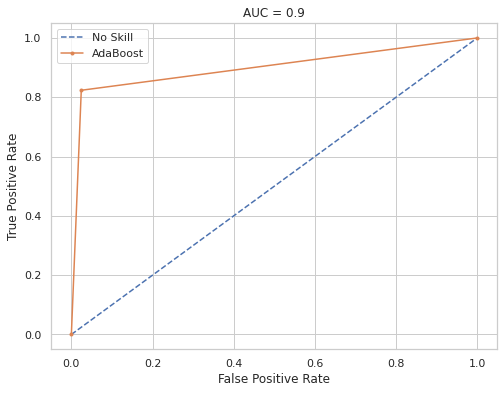

In [ ]:

## Display ROC curve
plt.figure(figsize=(8,6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_adb)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='AdaBoost' , marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f"AUC = {round(roc_auc,3)}")
# show the plot
plt.show()


The ROC curve for AdaBoost.

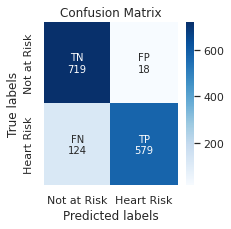

In [ ]:
# Get the confusion matrix for test
plt.figure(figsize=(3,3));
labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, y_pred_adb)

cat = ['TN','FP','FN','TP']
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot();
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

The confusion matrix above displays the True positives (TP), False Negatives (FN), False positives (FP) and True Negatives (TN).

In [ ]:
# Store the metrics to dataframe
metrics_df['AdaBoost']=[roc_auc,precision,recall,f1,accuracy,kappa]

The metrics are stored in a DataFrame to compare the results.

##XGB Classifier

Training XGBClassifier model on the Training set

In [ ]:
# Define XGB model
classifier = XGBClassifier(random_state=0)
classifier.fit(X_train, y_train)

XGBClassifier()

Next we use the Extra Gradient Boost(XGB) classifier. We fit the training data.

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred_xgb = classifier.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_xgb).ravel()
tp, tn, fp, fn

(576, 728, 9, 127)

In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.51388889 0.62673611 0.98611111 0.97916667 0.98958333 0.98611111
 0.984375   0.98263889 0.99304348 0.98086957]
The Cross Validation accuracy is: 90.23%


Classification report

In [ ]:
# Print classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91       737
         1.0       0.98      0.82      0.89       703

    accuracy                           0.91      1440
   macro avg       0.92      0.90      0.90      1440
weighted avg       0.92      0.91      0.90      1440



The classification report for the predicted data using XGB is shown here.

In [ ]:
## Calculate the diff Metrics
roc_auc = roc_auc_score(y_test, y_pred_xgb)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
f1=2*precision*recall/(recall+precision)
print ("F1-Score {:.3f}".format(f1))
accuracy =accuracy_score(y_test, y_pred_xgb)
print("Accuracy {:.3f}".format(accuracy))
kappa=cohen_kappa_score(y_test, y_pred_xgb)
print("Cohen's Kappa Score {:.3f}".format(kappa))


ROC-AUC: 0.904
Precision: 0.985
Recall: 0.819
F1-Score 0.894
Accuracy 0.906
Cohen's Kappa Score 0.810


With XGB also we are getting an excellent Cohen's Kappa score and a very high precision and F1-score.

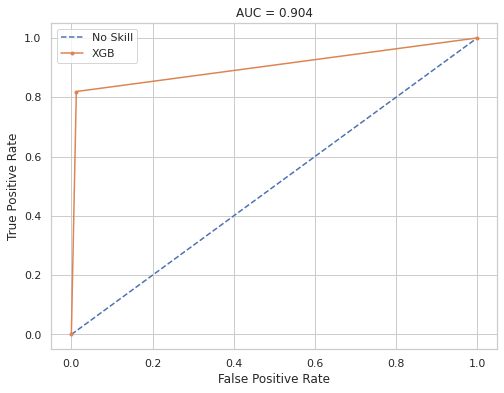

In [ ]:
## Display ROC curve
plt.figure(figsize=(8,6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='XGB' , marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f"AUC = {round(roc_auc,3)}")
# show the plot
plt.show()


The plot shows the ROC curve for XGB classifier. We get a good value for AUC around 0.9

In [ ]:
# Store the scores in a Dataframe
metrics_df['XGB']=[roc_auc,precision,recall,f1,accuracy,kappa]

The results are saved for comparison of different models afterwards.

*Tuning the hyper parameters*

In [ ]:
params = {
    'n_estimators': [50,100, 200],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs2.fit(X_train, y_train)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)

Best score: 0.9492518820333092
Best score: {'base_score': 0.2, 'booster': 'gbtree', 'gamma': 1, 'learning_rate': 0.05, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.5}


The parameters are defined for Grid search along with a three fold cross validation and scoring criterion of roc_auc. We iterate through n_estimators which is number of estimators, learning_rate i.e the learning rate of the model, 

As default booster in xgboost is gbtree not including that in our new model definition.

In [ ]:
base_score=gs2.best_params_['base_score']
booster=gs2.best_params_['booster']
gamma=gs2.best_params_['gamma']
learning_rate=gs2.best_params_['learning_rate']
n_estimators=gs2.best_params_['n_estimators']
learning_rate=gs2.best_params_['learning_rate']

reg_alpha=gs2.best_params_['reg_alpha']
reg_lambda=gs2.best_params_['reg_lambda']

In [ ]:
# Fit model with tuned parameters
classifier_tuned = XGBClassifier(random_state=0,base_score=base_score, booster=booster, gamma= gamma, learning_rate= learning_rate, 
                                 n_estimators= n_estimators, reg_alpha= reg_alpha, reg_lambda= reg_lambda)
classifier_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.2, gamma=1, learning_rate=0.05, reg_lambda=0.5)

In [ ]:
#Cross Validation
cv_results_tuned = cross_val_score(classifier_tuned, X, y, cv=10) 

print (f"Cross-validated scores {cv_results_tuned}")
print(f"The Cross Validation accuracy is: {round(cv_results_tuned.mean() * 100,2)}%")

Cross-validated scores [0.50694444 0.61458333 0.99479167 0.98611111 0.99305556 0.98611111
 0.98958333 0.98958333 0.99130435 0.9826087 ]
The Cross Validation accuracy is: 90.35%


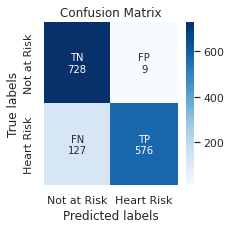

In [ ]:

# Get the confusion matrix for test
plt.figure(figsize=(3,3));
labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, y_pred_xgb)

cat = ['TN','FP','FN','TP']
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot();
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

We have the confusion matrix for the XGB classifier, it displays the True positives (TP), False Negatives (FN), False positives (FP) and True Negatives (TN).

## AdaBoost with SVC

In [ ]:
# Adaboost with SVC as estimator
clf_adb_svc = AdaBoostClassifier(random_state=1,base_estimator=SVC(kernel='rbf', C=1E6,random_state=1,probability=True),learning_rate=0.1,n_estimators=20)
clf_adb_svc.fit(X_train, y_train)

# Predict test data
y_pred_adb_svc=clf_adb_svc.predict(X_test)
## Metrics
roc_auc = roc_auc_score(y_test, y_pred_adb_svc)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, y_pred_adb_svc)
recall = recall_score(y_test, y_pred_adb_svc)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
f1=2*precision*recall/(recall+precision)
print ("F1-Score {:.3f}".format(f1))
accuracy =accuracy_score(y_test, y_pred_adb_svc)
print("Accuracy {:.3f}".format(accuracy))
kappa=cohen_kappa_score(y_test, y_pred_adb_svc)
print("Cohen's Kappa Score {:.3f}".format(kappa))

ROC-AUC: 0.878
Precision: 0.929
Recall: 0.815
F1-Score 0.868
Accuracy 0.879
Cohen's Kappa Score 0.758


With Adaboost classisfier we have used Support vector with Radial basis function kernel as the base classifier and a smaller learning rate of 0.05 and low number of estimators. We observe a better Cohen's Kappa score and accuracy compared to using only SVC

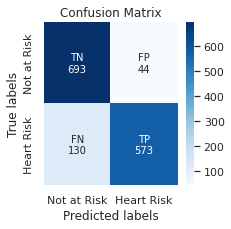

In [ ]:
# Get the confusion matrix for test
plt.figure(figsize=(3,3));
labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, y_pred_adb_svc)

cat = ['TN','FP','FN','TP']
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot();
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

We have the confusion matrix shown above, it displays the True positives (TP), False Negatives (FN), False positives (FP) and True Negatives (TN).

In [ ]:
# Store the results in DataFrame  
metrics_df['AdB_SVC']=[roc_auc,precision,recall,f1,accuracy,kappa]

The score results are stored in the dataframe.

##CatBoost Classifier

In [ ]:
# Define Catboost
clf_cat = CatBoostClassifier(random_state=1,verbose=False)
clf_cat.fit(X_train, y_train)

# Predict test data
y_pred_cat=clf_cat.predict(X_test)

# Calculate different Metrics
roc_auc = roc_auc_score(y_test, y_pred_cat)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, y_pred_cat)
recall = recall_score(y_test, y_pred_cat)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
f1=2*precision*recall/(recall+precision)
print ("F1-Score {:.3f}".format(f1))
accuracy =accuracy_score(y_test, y_pred_cat)
print("Accuracy {:.3f}".format(accuracy))
kappa=cohen_kappa_score(y_test, y_pred_cat)
print("Cohen's Kappa Score {:.3f}".format(kappa))

ROC-AUC: 0.903
Precision: 0.965
Recall: 0.834
F1-Score 0.895
Accuracy 0.904
Cohen's Kappa Score 0.808


CatBoost classifier id defined over here and we use it to fit teh train data and predict the test data. Then, we calculate the diffrent scores. Here also obserfve an excellent Cohen's Kappa score

In [ ]:
# store the results
metrics_df['CatBoost']=[roc_auc,precision,recall,f1,accuracy,kappa]

In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10,verbose=1) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross-validated scores [0.51388889 0.62673611 0.98611111 0.97916667 0.98958333 0.98611111
 0.984375   0.98263889 0.99304348 0.98086957]
The Cross Validation accuracy is: 90.23%


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.6s finished


*Classification report*

In [ ]:
# Print classification report
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91       737
         1.0       0.97      0.83      0.89       703

    accuracy                           0.90      1440
   macro avg       0.91      0.90      0.90      1440
weighted avg       0.91      0.90      0.90      1440



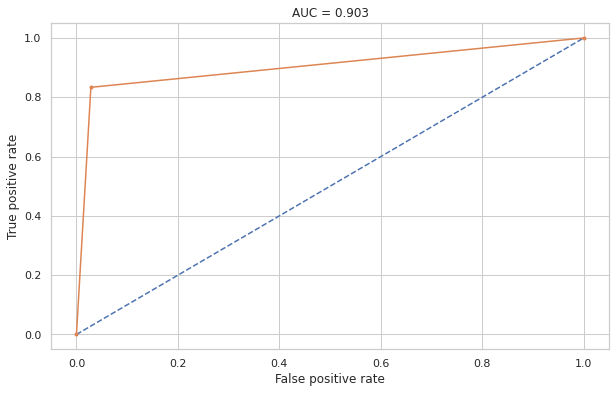

In [ ]:
# ROC curve and AUC 
probs = clf_cat.predict(X_test)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

With this model as well we get a good Area under curve value

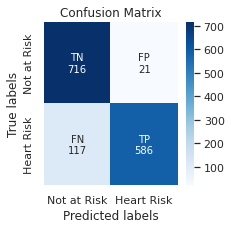

In [ ]:
# Get the confusion matrix for test dataset
plt.figure(figsize=(3,3));
labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, y_pred_cat)

cat = ['TN','FP','FN','TP']
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot();
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

The confusion matrix displays the True positives (TP), False Negatives (FN), False positives (FP) and True Negatives (TN).

# Stacking

In [ ]:
# define the base models
level0 = list()
level0.append(('knn', KNeighborsClassifier(n_neighbors = 5, weights = 'distance',metric = 'manhattan')))
level0.append(('Bag', DecisionTreeClassifier(random_state=1)))
level0.append(('svm', SVC(kernel='rbf', C=1000,random_state=1,gamma=1)))

# define meta learner model
level1 = LogisticRegression(random_state=1)

# define the stacking model
model = StackingClassifier(estimators=level0, final_estimator=level1,cv=5)
# fit the model on all available data
model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('knn',
                                KNeighborsClassifier(metric='manhattan',
                                                     weights='distance')),
                               ('Bag', DecisionTreeClassifier(random_state=1)),
                               ('svm', SVC(C=1000, gamma=1, random_state=1))],
                   final_estimator=LogisticRegression(random_state=1))

Finally we use Stacking, a method where we combine multiple models like KNN, Decision Tree and SVC and use their individual predictions as an input for Logistic Regression. We train this Logistic Regression model against the actual targets and use this combination to predict our test data.  

In [ ]:
## Predict test data
y_pred_st=model.predict(X_test)

## Metrics
roc_auc = roc_auc_score(y_test, y_pred_st)
print("ROC-AUC: {:.3f}".format(roc_auc))
precision = precision_score(y_test, y_pred_st)
recall = recall_score(y_test, y_pred_st)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
f1=2*precision*recall/(recall+precision)
print ("F1-Score {:.3f}".format(f1))
accuracy =accuracy_score(y_test, y_pred_st)
print ("Accuracy {:.3f}".format(accuracy))
kappa=cohen_kappa_score(y_test, y_pred_st)
print("Cohen's Kappa Score {:.3f}".format(kappa))

ROC-AUC: 0.924
Precision: 0.929
Recall: 0.915
F1-Score 0.922
Accuracy 0.924
Cohen's Kappa Score 0.848


Looking at the scores we see it has the best Cohen's Kappa score , an indication of the effectiveness of the model against varied datasets. Also we see significant improvement in Recall score compared to others.

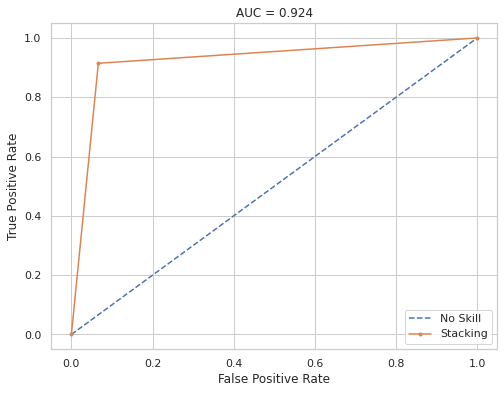

In [ ]:
## Display ROC curve
plt.figure(figsize=(8,6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_st)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='Stacking' , marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f"AUC = {round(roc_auc,3)}")
# show the plot
plt.show()

The ROC curve for the Stacking classifier with the best value for area under curve.

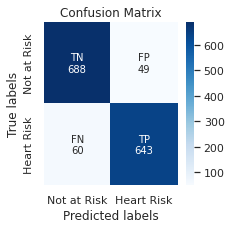

In [ ]:
# Get the confusion matrix for test dataset
plt.figure(figsize=(3,3));
labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, y_pred_st)

cat = ['TN','FP','FN','TP']
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot();
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

We have the confusion matrix for the Stacking model, it displays the True positives (TP), False Negatives (FN), False positives (FP) and True Negatives (TN).

In [ ]:
# Store the results in DataFrame  
metrics_df['Stacking']=[roc_auc,precision,recall,f1,accuracy,kappa]

# **Conclusion**

In [ ]:
# Display the final dataframe of scores for all models
metrics_df

,SVC,KNN,DecTree,RF,Bagging,AdaBoost,XGB,AdB_SVC,CatBoost,Stacking
ROC-AUC,0.904037,0.913042,0.894835,0.897701,0.896400,0.899595,0.903567,0.877688,0.902538,0.924083
Precision,0.931402,0.890392,0.994652,0.927803,0.952769,0.969849,0.984615,0.928687,0.965404,0.929191
Recall,0.869132,0.935989,0.793741,0.859175,0.832148,0.823613,0.819346,0.815078,0.833570,0.914651
F1-Score,0.899191,0.912621,0.882911,0.900232,0.888383,0.890769,0.894410,0.868182,0.894656,0.921864
Accuracy,0.904861,0.912500,0.897222,0.898611,0.897917,0.901389,0.905556,0.879167,0.904167,0.924306
Cohens Kappa Score,0.809322,0.825109,0.793367,0.820066,0.795121,0.801979,0.810271,0.757514,0.807620,0.848472


After training and testing the data on multiple models ranging from simple to ensembled approaches, we have the result for different scores like ROC-AUC, Precision, Recall, F1, Accuracy and Cohen's Kappa score at a single place. On comparing the Cohen's kappa score we can observe that Stacking has the best value followed by Support Vector Classifier. Also if we go back to our problem statement, our goal is to predict the risk of heart disease. In this type of problem our priority should be to reduce the number of False Negatives or find maximum Recall score. If we misclassify someone as having no risk to heart disease, it can be highly detrimental, it can lead to loss of life. Stacking gives us an excellent Recall and at the same time dosesn't compromise on Precision. If we require a model with more strict Recall values we can opt for KNN.

For future work we need to look for more optimal methods to handle the data imbalance. We can also go for hyper parameter tuning with more range of values and more number of parameters. More sophisticated approach like Neural nets can be used. With stacking we can use more optimal version of the base models and we can check with more cobinations of base models.